In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr
from pandas_datareader import data as pdr
from datetime import datetime

In [2]:
data_path0 = Path.cwd().parent / "data processed" / "ads_dataset.csv"
print("ADS dataset")
print("Full file path: ",data_path0)
print("File exists: ",data_path0.exists())
print("")

data_path1 = Path.cwd().parent / "data raw" / "RZDAT_updated.xlsx"
print("Ramey and Zubairy (2018) dataset:")
print("Full file path: ",data_path1)
print("File exists: ",data_path1.exists())
print("")

data_path2 = Path.cwd().parent / "data raw" / "military_spending_1890_1940.csv"
print("Defense spending dataset")
print("Full file path: ",data_path2)
print("File exists: ",data_path1.exists())

ADS dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/ads_dataset.csv
File exists:  True

Ramey and Zubairy (2018) dataset:
Full file path:  /Users/awalters/escp_phd/govt_spending/data raw/RZDAT_updated.xlsx
File exists:  True

Defense spending dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data raw/military_spending_1890_1940.csv
File exists:  True


In [3]:
df_ads = pd.read_csv(data_path0)
df_ads = df_ads.copy()
df_ads["date"] = pd.to_datetime(df_ads["date"])

In [4]:
df_ads

,date,pdvmily,rgdppc,govpc,tbill,totdefgdp,feddebtgdp,tfp_adj
0,1890-01-01,0.000000,-5.377503,-8.489825,4.247273,0.841634,8.122039,1.000000
1,1890-04-01,0.100799,-5.367321,-8.361955,4.038435,0.744001,7.814325,1.000731
2,1890-07-01,0.000000,-5.357144,-8.254742,4.397253,0.411837,7.330389,1.019988
3,1890-10-01,0.000000,-5.339102,-8.254618,5.452498,0.412199,6.976309,1.038773
4,1891-01-01,0.000000,-5.345935,-8.304856,4.306070,0.359541,6.808374,1.035873
...,...,...,...,...,...,...,...,...
499,2014-10-01,0.000000,-2.986680,-4.704116,0.020000,-3.839157,73.757791,2.983326
500,2015-01-01,0.000000,-2.986857,-4.710307,0.030000,-3.516293,74.028490,2.983944
501,2015-04-01,0.000000,-2.978942,-4.707879,0.020000,-2.778320,73.221562,2.987593
502,2015-07-01,0.000000,-2.976091,-4.706336,0.040000,-3.644487,75.684828,2.987491


In [5]:
start = datetime(1890, 1, 1)
end = datetime.today()

series = ["FDEFX",  #quarterly, seasonally adj annual rate, nominal, billions, 1947Q1 - 2025Q2
          "A824RC1A027NBEA", #Government consumption expenditures and gross investment: Federal: National defense, annual, billions 1929-2024
         ]
labels = ["mil_q","mil_annual"]

df_fred = pdr.DataReader(series, 'fred', start, end)
df_fred.columns = labels
df_fred.index = df_fred.index.rename("date")

In [6]:
df_fred

,mil_q,mil_annual
date,,
1929-01-01,NaN,1.056
1930-01-01,NaN,1.090
1931-01-01,NaN,1.081
1932-01-01,NaN,1.051
1933-01-01,NaN,0.999
...,...,...
2024-04-01,1064.344,NaN
2024-07-01,1104.161,NaN
2024-10-01,1122.731,NaN


In [7]:
df_archive = pd.read_csv(data_path2)
df_archive = df_archive.copy()

In [8]:
df_archive["date"] = pd.to_datetime(df_archive["year"].astype(str) + "-01-01")
df_archive = df_archive.rename(columns={"total": "archive_values"})
df_archive["archive_values"] = df_archive["archive_values"].astype(str).str.strip()
df_archive["archive_values"] = df_archive["archive_values"].str.replace(",", "", regex=False).astype("int64")
df_archive["archive_values"] /= 1000000000

In [9]:
df_rz = pd.read_excel(data_path1, sheet_name=1)

In [10]:
time_col = df_rz.columns[0]
df_rz = df_rz.rename(columns={time_col: "year_frac"})

df_rz["year"] = df_rz["year_frac"].astype(int)
df_rz["quarter"] = ((df_rz["year_frac"] - df_rz["year"]) * 4 + 1).round().astype(int)

df_rz["date"] = pd.PeriodIndex.from_fields(
    year=df_rz["year"].astype(int).to_numpy(),
    quarter=df_rz["quarter"].astype(int).to_numpy(),
    freq="Q"
)

df_rz = df_rz.set_index("date").sort_index()
df_rz.index = df_rz.index.to_timestamp(how="start")

df_rz = df_rz.drop(columns=["year_frac", "year", "quarter"])

df_rz = df_rz.reset_index()

In [11]:
df_rz = df_rz[['date','ngdp']]

In [12]:
df_rz

,date,ngdp
0,1875-01-01,NaN
1,1875-04-01,NaN
2,1875-07-01,NaN
3,1875-10-01,NaN
4,1876-01-01,NaN
...,...,...
575,2018-10-01,20813.3
576,2019-01-01,21001.6
577,2019-04-01,21289.3
578,2019-07-01,21505.0


In [13]:
df = df_ads.copy()
df = df.merge(df_archive.drop(columns=["year","navy","war"]), on="date", how="left")
df = df.merge(df_fred, on="date", how="left")
df = df.merge(df_rz, on="date", how="left")
df = df.set_index('date')

<Axes: xlabel='date'>

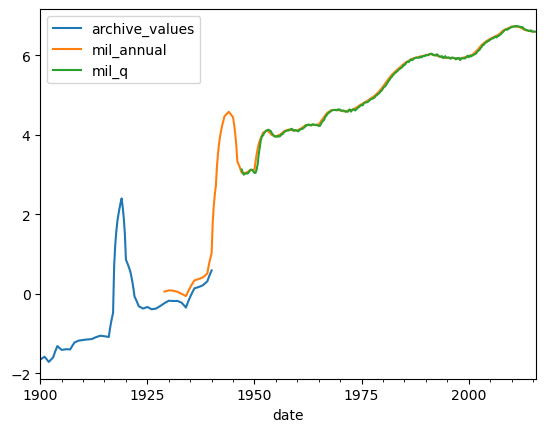

In [14]:
np.log(df[["archive_values","mil_annual","mil_q"]].loc[(df.index >= "1900-01-01")].interpolate(limit_area="inside")).plot()

In [15]:
overlap = df[["archive_values", "mil_annual"]].dropna()

k = np.median(overlap["mil_annual"] / overlap["archive_values"])
k

np.float64(1.2634712954324563)

In [16]:
df["archive_scaled"] = df["archive_values"] * k

In [17]:
check = pd.DataFrame({
    "archive_scaled": df["archive_scaled"],
    "mil_annual":     df["mil_annual"],
})

(check["mil_annual"] / check["archive_scaled"]).describe()

count    12.000000
mean      1.020936
std       0.073801
min       0.963932
25%       0.966690
50%       1.000000
75%       1.035492
max       1.228048
dtype: float64

<Axes: xlabel='date'>

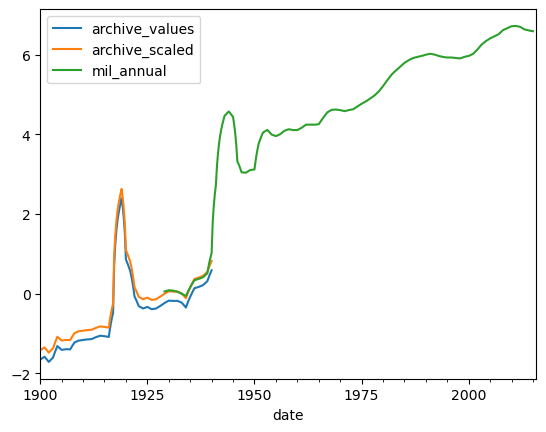

In [18]:
np.log(df[["archive_values","archive_scaled","mil_annual"]].loc[(df.index >= "1900-01-01")].interpolate(limit_area="inside")).plot()

In [19]:
df["mil_merged"] = (
    df["mil_q"]
      .combine_first(df["mil_annual"])
      .combine_first(df["archive_scaled"])
)

df.drop(columns=["mil_q", "mil_annual", "archive_scaled", "archive_values"], inplace=True)
df["mil_merged"] = df.mil_merged.interpolate()

In [20]:
df["def_gdp"] = df["mil_merged"]/df["ngdp"]
df["def_delta"] = (df["def_gdp"].shift(-4) - df["def_gdp"])/4

In [21]:
df2 = pd.DataFrame()
df2.index = df.index

In [22]:
df2['def_gdp'] = (df[['def_gdp']]*4).diff()
df2['pdvmily'] = df['pdvmily']
df2["chg_4q"] = df["def_gdp"].shift(-4) - df["def_gdp"]

<Axes: xlabel='date'>

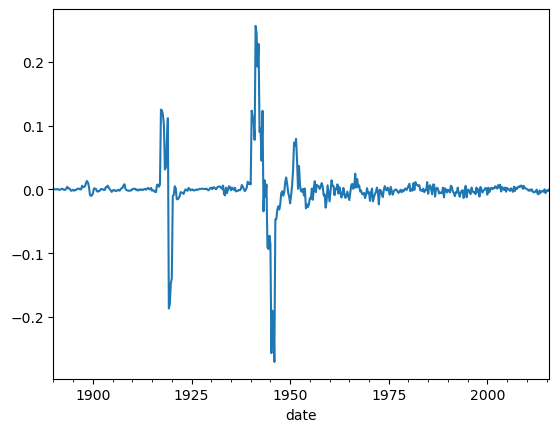

In [23]:
df2['def_gdp'].plot()

<Axes: xlabel='date'>

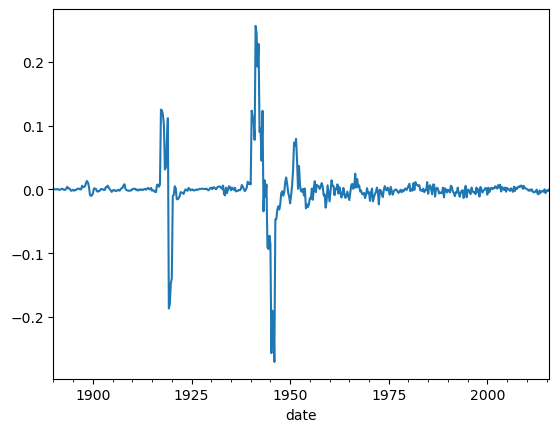

In [24]:
df2['def_gdp'].plot()

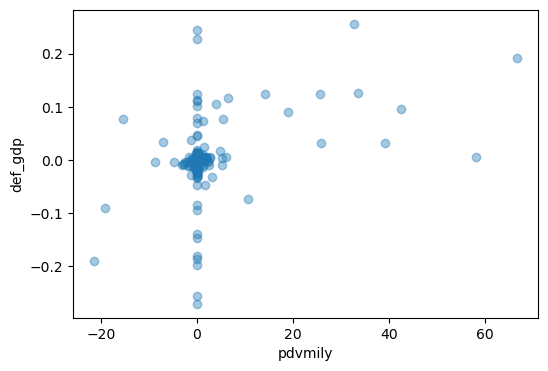

In [25]:
plt.figure(figsize=(6,4))
plt.scatter(df2["pdvmily"], df2["def_gdp"], alpha=0.4)
plt.xlabel("pdvmily")
plt.ylabel("def_gdp")
plt.show()

In [26]:
df2.corr()

,def_gdp,pdvmily,chg_4q
def_gdp,1.000000,0.386823,0.662766
pdvmily,0.386823,1.000000,0.382291
chg_4q,0.662766,0.382291,1.000000


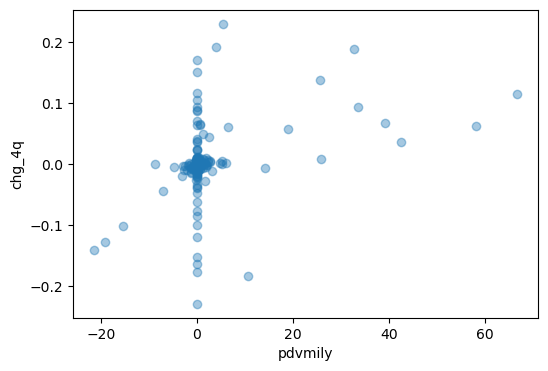

In [27]:
plt.figure(figsize=(6,4))
plt.scatter(df2["pdvmily"], df2["chg_4q"], alpha=0.4)
plt.xlabel("pdvmily")
plt.ylabel("chg_4q")
plt.show()

In [28]:
df.drop(columns=["mil_merged", "pdvmily","def_gdp"], inplace=True)

In [29]:
df["def_delta"] *= 100

df = df.loc[df.index >= "1890-01-01"] 
df = df.dropna()

In [30]:
cols_var = [
    "def_delta", #military spending as percent of gdp, change over next year
    "rgdppc", #real gdp per capita
    "govpc", #real government spending per capita
    "tbill", #fed funds rate
    "totdefgdp", #deficit as percent of gdp
    "feddebtgdp", #debt as percent of gdp
    "tfp_adj" #adjusted tfp
    ]

df = df[cols_var].reset_index().copy()

In [31]:
df

,date,def_delta,rgdppc,govpc,tbill,totdefgdp,feddebtgdp,tfp_adj
0,1890-01-01,0.008303,-5.377503,-8.489825,4.247273,0.841634,8.122039,1.000000
1,1890-04-01,0.003715,-5.367321,-8.361955,4.038435,0.744001,7.814325,1.000731
2,1890-07-01,-0.002246,-5.357144,-8.254742,4.397253,0.411837,7.330389,1.019988
3,1890-10-01,-0.004014,-5.339102,-8.254618,5.452498,0.412199,6.976309,1.038773
4,1891-01-01,-0.005413,-5.345935,-8.304856,4.306070,0.359541,6.808374,1.035873
...,...,...,...,...,...,...,...,...
495,2013-10-01,-0.073181,-3.003386,-4.697843,0.060000,-3.480437,73.254532,2.980584
496,2014-01-01,-0.071685,-3.007488,-4.701208,0.050000,-3.928921,74.179534,2.980497
497,2014-04-01,-0.054896,-2.998031,-4.700774,0.030000,-3.958314,74.000651,2.978646
498,2014-07-01,-0.071426,-2.989640,-4.697037,0.030000,-3.986403,73.657026,2.986394


In [32]:
np.exp(df[['rgdppc','govpc','tfp_adj']])

,rgdppc,govpc,tfp_adj
0,0.004619,0.000206,2.718282
1,0.004667,0.000234,2.720271
2,0.004714,0.000260,2.773161
3,0.004800,0.000260,2.825748
4,0.004767,0.000247,2.817565
...,...,...,...
495,0.049619,0.009115,19.699312
496,0.049416,0.009084,19.697601
497,0.049885,0.009088,19.661169
498,0.050306,0.009122,19.814103


In [33]:
df.to_csv(Path.cwd().parent / "data processed" / "ads_dataset_w_def.csv", index=False)